In [66]:
from jupyterthemes import jtplot
from tensorflow import set_random_seed
set_random_seed(42)
jtplot.style()
# Constantes
SEED = 42
PNLN = 0.17
m = 64
tau = 1
delta = 2

In [67]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from matplotlib import pyplot as plt
from tensorflow.keras import layers
from keras import regularizers
from tensorflow import keras
import numpy as np
import pandas as pd

In [68]:
from Funciones import GenersConjuntos
from Funciones import plot_history

In [69]:
# La principal diferencia radica en el uso de la regularizacion L2
def ModMLPReg(show=True):
    inputs = keras.Input(shape=(m))
    x = layers.Dense(64, activation='sigmoid',activity_regularizer=regularizers.l2(PNLN))(inputs)
    x = layers.Dense(128, activation='relu',activity_regularizer=regularizers.l2(PNLN))(x)
    x = layers.Dense(256, activation='relu',activity_regularizer=regularizers.l2(PNLN))(x)
    outputs = layers.Dense(delta, activation='linear',activity_regularizer=regularizers.l2(PNLN))(x)

    model = keras.Model(inputs=inputs, outputs=outputs, name='forecasting')
    
    if(show):
        model.summary()
    
    return model

<h3> Lectura y analisis de la serie de tiempo </h3>

Para comenzar se lee la serie de tiempo desde el archivo csv

In [70]:
TS = pd.read_csv('TimesSeries\Electric_Production.csv')

In [71]:
TS.info() # Se reviza que la serie de tiempo no tenga nulos

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397 entries, 0 to 396
Data columns (total 2 columns):
DATE     397 non-null object
Value    397 non-null float64
dtypes: float64(1), object(1)
memory usage: 6.3+ KB


La serie de tiempo es tomada desde la columna value

In [72]:
serie = TS.Value

Se pueden revizar su media, su maximo, su minimo, y su promedio

In [73]:
print('Media:', serie.mean())
print('Maximo:', serie.max())
print('Minimo:', serie.min())
print('STD:', serie.std())

Media: 88.84721763224182
Maximo: 129.4048
Minimo: 55.3151
STD: 15.387833664730902


La serie es convertiza a numpy array para un mejor manejo, a su vez es ploteada para observar su forma

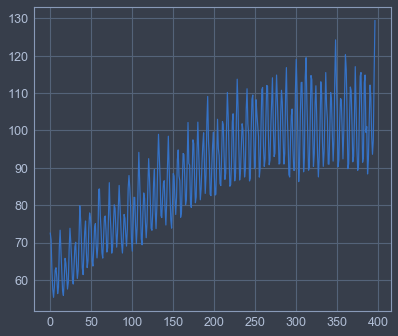

In [74]:
serie = np.array(serie)
plt.plot(serie)
plt.show()

Posteriormente se estandariza la serie y se obtienen los conjuntos de datos con los cuales se ha de entrenar la red

In [75]:
X_train, X_val, X_test, y_train, y_val, y_test=  GenersConjuntos(serie, 0.3, 0.2)

In [76]:
X_val.shape

(47, 64)

<h3> Diseño y entrenamiento de la red neuronal </h3>

In [77]:
model = ModMLPReg()

Model: "forecasting"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 64)]              0         
_________________________________________________________________
dense_16 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_17 (Dense)             (None, 128)               8320      
_________________________________________________________________
dense_18 (Dense)             (None, 256)               33024     
_________________________________________________________________
dense_19 (Dense)             (None, 2)                 514       
Total params: 46,018
Trainable params: 46,018
Non-trainable params: 0
_________________________________________________________________


Una vez que el modelo esta creado se compila y se entrena.

En la compilación se utiliza como funcion de perdida el Error cuadratico medio en convinacion con el gradiente estocastico, el tercer parametro son las metricas en este caso se utilizan el error absoluto medio, el error cuadratico medio y accuracy, aunque la ultima no es una buena referencia cuando se realiza prediccion de series de tiempo (forcasting) es más comun su utilización en clasificación.

In [78]:
model.compile(loss="mean_squared_error", optimizer="sgd", metrics=['mae', 'mse','accuracy'])

In [79]:
#callback = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = model.fit(X_train, y_train,
                    batch_size=64,
                    #callbacks=[callback],
                    epochs=2000,
                    validation_data=(X_val, y_val))

test_scores = model.evaluate(X_test, y_test, batch_size=32)
print('Test loss:', test_scores[0])
print('Test mae:', test_scores[1])
print('Test mse:', test_scores[2])
print('Test acc:', test_scores[3])

Train on 185 samples, validate on 47 samples
Epoch 1/2000
185/185 [==============================] - 0s 1ms/sample - loss: 7.6395 - mean_absolute_error: 0.6567 - mean_squared_error: 0.6684 - acc: 0.4757 - val_loss: 6.0541 - val_mean_absolute_error: 0.5976 - val_mean_squared_error: 0.5232 - val_acc: 0.4255
Epoch 2/2000
185/185 [==============================] - 0s 108us/sample - loss: 5.9383 - mean_absolute_error: 0.6245 - mean_squared_error: 0.6119 - acc: 0.4757 - val_loss: 5.0940 - val_mean_absolute_error: 0.5814 - val_mean_squared_error: 0.4964 - val_acc: 0.5106
Epoch 3/2000
185/185 [==============================] - 0s 124us/sample - loss: 5.1245 - mean_absolute_error: 0.6062 - mean_squared_error: 0.5801 - acc: 0.5514 - val_loss: 4.5707 - val_mean_absolute_error: 0.5739 - val_mean_squared_error: 0.4841 - val_acc: 0.5106
Epoch 4/2000
185/185 [==============================] - 0s 108us/sample - loss: 4.6649 - mean_absolute_error: 0.5984 - mean_squared_error: 0.5687 - acc: 0.6432 - val

Epoch 32/2000
185/185 [==============================] - 0s 140us/sample - loss: 3.3790 - mean_absolute_error: 0.5228 - mean_squared_error: 0.4285 - acc: 0.7568 - val_loss: 3.2230 - val_mean_absolute_error: 0.4836 - val_mean_squared_error: 0.3487 - val_acc: 0.7872
Epoch 33/2000
185/185 [==============================] - 0s 113us/sample - loss: 3.3654 - mean_absolute_error: 0.5197 - mean_squared_error: 0.4235 - acc: 0.7622 - val_loss: 3.2099 - val_mean_absolute_error: 0.4801 - val_mean_squared_error: 0.3440 - val_acc: 0.7872
Epoch 34/2000
185/185 [==============================] - 0s 124us/sample - loss: 3.3517 - mean_absolute_error: 0.5166 - mean_squared_error: 0.4181 - acc: 0.7405 - val_loss: 3.1971 - val_mean_absolute_error: 0.4768 - val_mean_squared_error: 0.3396 - val_acc: 0.7872
Epoch 35/2000
185/185 [==============================] - 0s 119us/sample - loss: 3.3381 - mean_absolute_error: 0.5133 - mean_squared_error: 0.4125 - acc: 0.7568 - val_loss: 3.1845 - val_mean_absolute_error

Epoch 63/2000
185/185 [==============================] - 0s 108us/sample - loss: 3.0251 - mean_absolute_error: 0.4491 - mean_squared_error: 0.3167 - acc: 0.7730 - val_loss: 2.8869 - val_mean_absolute_error: 0.4114 - val_mean_squared_error: 0.2569 - val_acc: 0.7660
Epoch 64/2000
185/185 [==============================] - 0s 108us/sample - loss: 3.0154 - mean_absolute_error: 0.4476 - mean_squared_error: 0.3145 - acc: 0.7676 - val_loss: 2.8777 - val_mean_absolute_error: 0.4098 - val_mean_squared_error: 0.2549 - val_acc: 0.7660
Epoch 65/2000
185/185 [==============================] - 0s 108us/sample - loss: 3.0060 - mean_absolute_error: 0.4455 - mean_squared_error: 0.3119 - acc: 0.7730 - val_loss: 2.8687 - val_mean_absolute_error: 0.4082 - val_mean_squared_error: 0.2530 - val_acc: 0.7660
Epoch 66/2000
185/185 [==============================] - 0s 102us/sample - loss: 2.9969 - mean_absolute_error: 0.4439 - mean_squared_error: 0.3096 - acc: 0.7676 - val_loss: 2.8597 - val_mean_absolute_error

185/185 [==============================] - 0s 108us/sample - loss: 2.7725 - mean_absolute_error: 0.4096 - mean_squared_error: 0.2646 - acc: 0.7838 - val_loss: 2.6420 - val_mean_absolute_error: 0.3753 - val_mean_squared_error: 0.2162 - val_acc: 0.7660
Epoch 94/2000
185/185 [==============================] - 0s 113us/sample - loss: 2.7649 - mean_absolute_error: 0.4102 - mean_squared_error: 0.2655 - acc: 0.7946 - val_loss: 2.6347 - val_mean_absolute_error: 0.3739 - val_mean_squared_error: 0.2147 - val_acc: 0.7660
Epoch 95/2000
185/185 [==============================] - 0s 102us/sample - loss: 2.7579 - mean_absolute_error: 0.4088 - mean_squared_error: 0.2639 - acc: 0.7946 - val_loss: 2.6274 - val_mean_absolute_error: 0.3725 - val_mean_squared_error: 0.2132 - val_acc: 0.7872
Epoch 96/2000
185/185 [==============================] - 0s 102us/sample - loss: 2.7499 - mean_absolute_error: 0.4072 - mean_squared_error: 0.2613 - acc: 0.8000 - val_loss: 2.6201 - val_mean_absolute_error: 0.3724 - val

185/185 [==============================] - 0s 108us/sample - loss: 2.5648 - mean_absolute_error: 0.3886 - mean_squared_error: 0.2387 - acc: 0.8432 - val_loss: 2.4375 - val_mean_absolute_error: 0.3560 - val_mean_squared_error: 0.1950 - val_acc: 0.7660
Epoch 124/2000
185/185 [==============================] - 0s 113us/sample - loss: 2.5577 - mean_absolute_error: 0.3889 - mean_squared_error: 0.2390 - acc: 0.8378 - val_loss: 2.4312 - val_mean_absolute_error: 0.3550 - val_mean_squared_error: 0.1940 - val_acc: 0.7660
Epoch 125/2000
185/185 [==============================] - 0s 108us/sample - loss: 2.5515 - mean_absolute_error: 0.3877 - mean_squared_error: 0.2375 - acc: 0.8541 - val_loss: 2.4250 - val_mean_absolute_error: 0.3544 - val_mean_squared_error: 0.1934 - val_acc: 0.7660
Epoch 126/2000
185/185 [==============================] - 0s 102us/sample - loss: 2.5456 - mean_absolute_error: 0.3866 - mean_squared_error: 0.2364 - acc: 0.8432 - val_loss: 2.4187 - val_mean_absolute_error: 0.3544 - 

Epoch 154/2000
185/185 [==============================] - 0s 108us/sample - loss: 2.3784 - mean_absolute_error: 0.3732 - mean_squared_error: 0.2201 - acc: 0.8595 - val_loss: 2.2540 - val_mean_absolute_error: 0.3416 - val_mean_squared_error: 0.1800 - val_acc: 0.8085
Epoch 155/2000
185/185 [==============================] - 0s 102us/sample - loss: 2.3730 - mean_absolute_error: 0.3740 - mean_squared_error: 0.2217 - acc: 0.8703 - val_loss: 2.2486 - val_mean_absolute_error: 0.3404 - val_mean_squared_error: 0.1785 - val_acc: 0.8298
Epoch 156/2000
185/185 [==============================] - 0s 108us/sample - loss: 2.3672 - mean_absolute_error: 0.3722 - mean_squared_error: 0.2189 - acc: 0.8703 - val_loss: 2.2429 - val_mean_absolute_error: 0.3410 - val_mean_squared_error: 0.1793 - val_acc: 0.8298
Epoch 157/2000
185/185 [==============================] - 0s 102us/sample - loss: 2.3620 - mean_absolute_error: 0.3735 - mean_squared_error: 0.2207 - acc: 0.8757 - val_loss: 2.2374 - val_mean_absolute_e

Epoch 185/2000
185/185 [==============================] - 0s 110us/sample - loss: 2.2156 - mean_absolute_error: 0.3616 - mean_squared_error: 0.2070 - acc: 0.8757 - val_loss: 2.0925 - val_mean_absolute_error: 0.3333 - val_mean_squared_error: 0.1717 - val_acc: 0.8298
Epoch 186/2000
185/185 [==============================] - 0s 105us/sample - loss: 2.2102 - mean_absolute_error: 0.3631 - mean_squared_error: 0.2093 - acc: 0.8757 - val_loss: 2.0876 - val_mean_absolute_error: 0.3323 - val_mean_squared_error: 0.1700 - val_acc: 0.8298
Epoch 187/2000
185/185 [==============================] - 0s 106us/sample - loss: 2.2058 - mean_absolute_error: 0.3626 - mean_squared_error: 0.2081 - acc: 0.8757 - val_loss: 2.0828 - val_mean_absolute_error: 0.3321 - val_mean_squared_error: 0.1700 - val_acc: 0.8298
Epoch 188/2000
185/185 [==============================] - 0s 142us/sample - loss: 2.2005 - mean_absolute_error: 0.3621 - mean_squared_error: 0.2080 - acc: 0.8757 - val_loss: 2.0779 - val_mean_absolute_e

Epoch 216/2000
185/185 [==============================] - ETA: 0s - loss: 2.0612 - mean_absolute_error: 0.3526 - mean_squared_error: 0.1854 - acc: 0.89 - 0s 97us/sample - loss: 2.0707 - mean_absolute_error: 0.3549 - mean_squared_error: 0.1997 - acc: 0.8811 - val_loss: 1.9498 - val_mean_absolute_error: 0.3252 - val_mean_squared_error: 0.1619 - val_acc: 0.8298
Epoch 217/2000
185/185 [==============================] - 0s 102us/sample - loss: 2.0661 - mean_absolute_error: 0.3541 - mean_squared_error: 0.1983 - acc: 0.8811 - val_loss: 1.9453 - val_mean_absolute_error: 0.3258 - val_mean_squared_error: 0.1630 - val_acc: 0.8298
Epoch 218/2000
185/185 [==============================] - 0s 97us/sample - loss: 2.0617 - mean_absolute_error: 0.3552 - mean_squared_error: 0.1999 - acc: 0.8865 - val_loss: 1.9410 - val_mean_absolute_error: 0.3251 - val_mean_squared_error: 0.1624 - val_acc: 0.8298
Epoch 219/2000
185/185 [==============================] - 0s 102us/sample - loss: 2.0574 - mean_absolute_err

185/185 [==============================] - 0s 108us/sample - loss: 1.9455 - mean_absolute_error: 0.3493 - mean_squared_error: 0.1935 - acc: 0.8865 - val_loss: 1.8267 - val_mean_absolute_error: 0.3201 - val_mean_squared_error: 0.1566 - val_acc: 0.8298
Epoch 247/2000
185/185 [==============================] - 0s 124us/sample - loss: 1.9416 - mean_absolute_error: 0.3469 - mean_squared_error: 0.1908 - acc: 0.8865 - val_loss: 1.8226 - val_mean_absolute_error: 0.3210 - val_mean_squared_error: 0.1578 - val_acc: 0.8298
Epoch 248/2000
185/185 [==============================] - 0s 108us/sample - loss: 1.9379 - mean_absolute_error: 0.3486 - mean_squared_error: 0.1928 - acc: 0.8811 - val_loss: 1.8188 - val_mean_absolute_error: 0.3204 - val_mean_squared_error: 0.1576 - val_acc: 0.8298
Epoch 249/2000
185/185 [==============================] - 0s 102us/sample - loss: 1.9338 - mean_absolute_error: 0.3483 - mean_squared_error: 0.1931 - acc: 0.8811 - val_loss: 1.8151 - val_mean_absolute_error: 0.3193 - 

Epoch 277/2000
185/185 [==============================] - 0s 108us/sample - loss: 1.8301 - mean_absolute_error: 0.3411 - mean_squared_error: 0.1844 - acc: 0.8811 - val_loss: 1.7132 - val_mean_absolute_error: 0.3161 - val_mean_squared_error: 0.1524 - val_acc: 0.8298
Epoch 278/2000
185/185 [==============================] - 0s 102us/sample - loss: 1.8266 - mean_absolute_error: 0.3429 - mean_squared_error: 0.1866 - acc: 0.8811 - val_loss: 1.7097 - val_mean_absolute_error: 0.3157 - val_mean_squared_error: 0.1521 - val_acc: 0.8298
Epoch 279/2000
185/185 [==============================] - 0s 108us/sample - loss: 1.8230 - mean_absolute_error: 0.3415 - mean_squared_error: 0.1852 - acc: 0.8811 - val_loss: 1.7063 - val_mean_absolute_error: 0.3163 - val_mean_squared_error: 0.1526 - val_acc: 0.8298
Epoch 280/2000
185/185 [==============================] - 0s 102us/sample - loss: 1.8194 - mean_absolute_error: 0.3423 - mean_squared_error: 0.1859 - acc: 0.8811 - val_loss: 1.7028 - val_mean_absolute_e

Epoch 308/2000
185/185 [==============================] - 0s 108us/sample - loss: 1.7265 - mean_absolute_error: 0.3379 - mean_squared_error: 0.1813 - acc: 0.8865 - val_loss: 1.6118 - val_mean_absolute_error: 0.3119 - val_mean_squared_error: 0.1484 - val_acc: 0.8298
Epoch 309/2000
185/185 [==============================] - 0s 108us/sample - loss: 1.7236 - mean_absolute_error: 0.3384 - mean_squared_error: 0.1818 - acc: 0.8919 - val_loss: 1.6088 - val_mean_absolute_error: 0.3110 - val_mean_squared_error: 0.1476 - val_acc: 0.8298
Epoch 310/2000
185/185 [==============================] - 0s 102us/sample - loss: 1.7205 - mean_absolute_error: 0.3370 - mean_squared_error: 0.1800 - acc: 0.8811 - val_loss: 1.6055 - val_mean_absolute_error: 0.3118 - val_mean_squared_error: 0.1487 - val_acc: 0.8298
Epoch 311/2000
185/185 [==============================] - 0s 102us/sample - loss: 1.7176 - mean_absolute_error: 0.3387 - mean_squared_error: 0.1817 - acc: 0.8811 - val_loss: 1.6025 - val_mean_absolute_e

Epoch 339/2000
185/185 [==============================] - 0s 108us/sample - loss: 1.6339 - mean_absolute_error: 0.3328 - mean_squared_error: 0.1755 - acc: 0.8811 - val_loss: 1.5209 - val_mean_absolute_error: 0.3071 - val_mean_squared_error: 0.1441 - val_acc: 0.8298
Epoch 340/2000
185/185 [==============================] - 0s 108us/sample - loss: 1.6312 - mean_absolute_error: 0.3331 - mean_squared_error: 0.1758 - acc: 0.8811 - val_loss: 1.5180 - val_mean_absolute_error: 0.3071 - val_mean_squared_error: 0.1445 - val_acc: 0.8298
Epoch 341/2000
185/185 [==============================] - 0s 95us/sample - loss: 1.6281 - mean_absolute_error: 0.3342 - mean_squared_error: 0.1771 - acc: 0.8811 - val_loss: 1.5152 - val_mean_absolute_error: 0.3057 - val_mean_squared_error: 0.1433 - val_acc: 0.8298
Epoch 342/2000
185/185 [==============================] - 0s 96us/sample - loss: 1.6253 - mean_absolute_error: 0.3318 - mean_squared_error: 0.1751 - acc: 0.8757 - val_loss: 1.5127 - val_mean_absolute_err

185/185 [==============================] - 0s 108us/sample - loss: 1.5530 - mean_absolute_error: 0.3280 - mean_squared_error: 0.1707 - acc: 0.8757 - val_loss: 1.4413 - val_mean_absolute_error: 0.3031 - val_mean_squared_error: 0.1416 - val_acc: 0.8298
Epoch 370/2000
185/185 [==============================] - 0s 113us/sample - loss: 1.5505 - mean_absolute_error: 0.3304 - mean_squared_error: 0.1734 - acc: 0.8757 - val_loss: 1.4389 - val_mean_absolute_error: 0.3013 - val_mean_squared_error: 0.1398 - val_acc: 0.8298
Epoch 371/2000
185/185 [==============================] - 0s 104us/sample - loss: 1.5479 - mean_absolute_error: 0.3280 - mean_squared_error: 0.1705 - acc: 0.8757 - val_loss: 1.4362 - val_mean_absolute_error: 0.3024 - val_mean_squared_error: 0.1414 - val_acc: 0.8298
Epoch 372/2000
185/185 [==============================] - 0s 102us/sample - loss: 1.5452 - mean_absolute_error: 0.3276 - mean_squared_error: 0.1705 - acc: 0.8757 - val_loss: 1.4337 - val_mean_absolute_error: 0.3033 - 

Epoch 400/2000
185/185 [==============================] - 0s 119us/sample - loss: 1.4768 - mean_absolute_error: 0.3251 - mean_squared_error: 0.1684 - acc: 0.8865 - val_loss: 1.3678 - val_mean_absolute_error: 0.2989 - val_mean_squared_error: 0.1366 - val_acc: 0.8511
Epoch 401/2000
185/185 [==============================] - 0s 102us/sample - loss: 1.4746 - mean_absolute_error: 0.3246 - mean_squared_error: 0.1666 - acc: 0.8919 - val_loss: 1.3653 - val_mean_absolute_error: 0.2992 - val_mean_squared_error: 0.1375 - val_acc: 0.8511
Epoch 402/2000
185/185 [==============================] - 0s 102us/sample - loss: 1.4720 - mean_absolute_error: 0.3239 - mean_squared_error: 0.1666 - acc: 0.8919 - val_loss: 1.3630 - val_mean_absolute_error: 0.2998 - val_mean_squared_error: 0.1380 - val_acc: 0.8511
Epoch 403/2000
185/185 [==============================] - 0s 108us/sample - loss: 1.4698 - mean_absolute_error: 0.3249 - mean_squared_error: 0.1671 - acc: 0.8919 - val_loss: 1.3605 - val_mean_absolute_e

Epoch 431/2000
185/185 [==============================] - 0s 108us/sample - loss: 1.4079 - mean_absolute_error: 0.3230 - mean_squared_error: 0.1655 - acc: 0.8973 - val_loss: 1.3006 - val_mean_absolute_error: 0.2947 - val_mean_squared_error: 0.1343 - val_acc: 0.8511
Epoch 432/2000
185/185 [==============================] - 0s 102us/sample - loss: 1.4057 - mean_absolute_error: 0.3189 - mean_squared_error: 0.1618 - acc: 0.8973 - val_loss: 1.2985 - val_mean_absolute_error: 0.2965 - val_mean_squared_error: 0.1356 - val_acc: 0.8511
Epoch 433/2000
185/185 [==============================] - 0s 102us/sample - loss: 1.4036 - mean_absolute_error: 0.3217 - mean_squared_error: 0.1645 - acc: 0.8973 - val_loss: 1.2966 - val_mean_absolute_error: 0.2954 - val_mean_squared_error: 0.1344 - val_acc: 0.8511
Epoch 434/2000
185/185 [==============================] - 0s 108us/sample - loss: 1.4015 - mean_absolute_error: 0.3193 - mean_squared_error: 0.1625 - acc: 0.8973 - val_loss: 1.2947 - val_mean_absolute_e

Epoch 462/2000
185/185 [==============================] - 0s 113us/sample - loss: 1.3455 - mean_absolute_error: 0.3160 - mean_squared_error: 0.1594 - acc: 0.8973 - val_loss: 1.2396 - val_mean_absolute_error: 0.2930 - val_mean_squared_error: 0.1340 - val_acc: 0.8511
Epoch 463/2000
185/185 [==============================] - 0s 102us/sample - loss: 1.3432 - mean_absolute_error: 0.3174 - mean_squared_error: 0.1612 - acc: 0.8973 - val_loss: 1.2384 - val_mean_absolute_error: 0.2928 - val_mean_squared_error: 0.1311 - val_acc: 0.8511
Epoch 464/2000
185/185 [==============================] - 0s 146us/sample - loss: 1.3413 - mean_absolute_error: 0.3174 - mean_squared_error: 0.1596 - acc: 0.9027 - val_loss: 1.2362 - val_mean_absolute_error: 0.2922 - val_mean_squared_error: 0.1316 - val_acc: 0.8511
Epoch 465/2000
185/185 [==============================] - 0s 108us/sample - loss: 1.3394 - mean_absolute_error: 0.3172 - mean_squared_error: 0.1601 - acc: 0.8973 - val_loss: 1.2345 - val_mean_absolute_e

Epoch 493/2000
185/185 [==============================] - 0s 102us/sample - loss: 1.2879 - mean_absolute_error: 0.3152 - mean_squared_error: 0.1588 - acc: 0.8973 - val_loss: 1.1848 - val_mean_absolute_error: 0.2884 - val_mean_squared_error: 0.1279 - val_acc: 0.8511
Epoch 494/2000
185/185 [==============================] - 0s 102us/sample - loss: 1.2863 - mean_absolute_error: 0.3137 - mean_squared_error: 0.1563 - acc: 0.8973 - val_loss: 1.1830 - val_mean_absolute_error: 0.2875 - val_mean_squared_error: 0.1277 - val_acc: 0.8511
Epoch 495/2000
185/185 [==============================] - 0s 101us/sample - loss: 1.2847 - mean_absolute_error: 0.3129 - mean_squared_error: 0.1565 - acc: 0.8973 - val_loss: 1.1816 - val_mean_absolute_error: 0.2882 - val_mean_squared_error: 0.1274 - val_acc: 0.8723
Epoch 496/2000
185/185 [==============================] - 0s 102us/sample - loss: 1.2829 - mean_absolute_error: 0.3138 - mean_squared_error: 0.1557 - acc: 0.8973 - val_loss: 1.1794 - val_mean_absolute_e

185/185 [==============================] - 0s 119us/sample - loss: 1.2379 - mean_absolute_error: 0.3102 - mean_squared_error: 0.1544 - acc: 0.9027 - val_loss: 1.1359 - val_mean_absolute_error: 0.2875 - val_mean_squared_error: 0.1271 - val_acc: 0.8511
Epoch 524/2000
185/185 [==============================] - 0s 108us/sample - loss: 1.2355 - mean_absolute_error: 0.3107 - mean_squared_error: 0.1534 - acc: 0.8973 - val_loss: 1.1341 - val_mean_absolute_error: 0.2867 - val_mean_squared_error: 0.1271 - val_acc: 0.8511
Epoch 525/2000
185/185 [==============================] - 0s 113us/sample - loss: 1.2341 - mean_absolute_error: 0.3114 - mean_squared_error: 0.1547 - acc: 0.8973 - val_loss: 1.1329 - val_mean_absolute_error: 0.2855 - val_mean_squared_error: 0.1253 - val_acc: 0.8511
Epoch 526/2000
185/185 [==============================] - 0s 102us/sample - loss: 1.2325 - mean_absolute_error: 0.3081 - mean_squared_error: 0.1512 - acc: 0.8973 - val_loss: 1.1312 - val_mean_absolute_error: 0.2875 - 

Epoch 554/2000
185/185 [==============================] - 0s 113us/sample - loss: 1.1889 - mean_absolute_error: 0.3049 - mean_squared_error: 0.1481 - acc: 0.8973 - val_loss: 1.0893 - val_mean_absolute_error: 0.2832 - val_mean_squared_error: 0.1244 - val_acc: 0.8511
Epoch 555/2000
185/185 [==============================] - 0s 129us/sample - loss: 1.1874 - mean_absolute_error: 0.3065 - mean_squared_error: 0.1496 - acc: 0.8973 - val_loss: 1.0877 - val_mean_absolute_error: 0.2833 - val_mean_squared_error: 0.1253 - val_acc: 0.8511
Epoch 556/2000
185/185 [==============================] - 0s 129us/sample - loss: 1.1860 - mean_absolute_error: 0.3071 - mean_squared_error: 0.1508 - acc: 0.9027 - val_loss: 1.0864 - val_mean_absolute_error: 0.2825 - val_mean_squared_error: 0.1241 - val_acc: 0.8511
Epoch 557/2000
185/185 [==============================] - 0s 49us/sample - loss: 1.1846 - mean_absolute_error: 0.3054 - mean_squared_error: 0.1489 - acc: 0.8973 - val_loss: 1.0849 - val_mean_absolute_er

185/185 [==============================] - 0s 119us/sample - loss: 1.1461 - mean_absolute_error: 0.3043 - mean_squared_error: 0.1473 - acc: 0.8973 - val_loss: 1.0480 - val_mean_absolute_error: 0.2815 - val_mean_squared_error: 0.1230 - val_acc: 0.8723
Epoch 585/2000
185/185 [==============================] - 0s 113us/sample - loss: 1.1447 - mean_absolute_error: 0.3040 - mean_squared_error: 0.1475 - acc: 0.9027 - val_loss: 1.0466 - val_mean_absolute_error: 0.2810 - val_mean_squared_error: 0.1228 - val_acc: 0.8723
Epoch 586/2000
185/185 [==============================] - 0s 108us/sample - loss: 1.1434 - mean_absolute_error: 0.3051 - mean_squared_error: 0.1487 - acc: 0.8973 - val_loss: 1.0457 - val_mean_absolute_error: 0.2797 - val_mean_squared_error: 0.1211 - val_acc: 0.8723
Epoch 587/2000
185/185 [==============================] - 0s 102us/sample - loss: 1.1421 - mean_absolute_error: 0.3023 - mean_squared_error: 0.1461 - acc: 0.9027 - val_loss: 1.0440 - val_mean_absolute_error: 0.2807 - 

185/185 [==============================] - 0s 102us/sample - loss: 1.1065 - mean_absolute_error: 0.3002 - mean_squared_error: 0.1449 - acc: 0.9027 - val_loss: 1.0100 - val_mean_absolute_error: 0.2800 - val_mean_squared_error: 0.1220 - val_acc: 0.8511
Epoch 615/2000
185/185 [==============================] - 0s 108us/sample - loss: 1.1051 - mean_absolute_error: 0.3006 - mean_squared_error: 0.1446 - acc: 0.9027 - val_loss: 1.0089 - val_mean_absolute_error: 0.2804 - val_mean_squared_error: 0.1221 - val_acc: 0.8511
Epoch 616/2000
185/185 [==============================] - 0s 108us/sample - loss: 1.1038 - mean_absolute_error: 0.3017 - mean_squared_error: 0.1457 - acc: 0.9027 - val_loss: 1.0079 - val_mean_absolute_error: 0.2794 - val_mean_squared_error: 0.1208 - val_acc: 0.8298
Epoch 617/2000
185/185 [==============================] - 0s 108us/sample - loss: 1.1029 - mean_absolute_error: 0.3006 - mean_squared_error: 0.1440 - acc: 0.8973 - val_loss: 1.0064 - val_mean_absolute_error: 0.2800 - 

Epoch 645/2000
185/185 [==============================] - 0s 113us/sample - loss: 1.0690 - mean_absolute_error: 0.2990 - mean_squared_error: 0.1438 - acc: 0.8973 - val_loss: 0.9740 - val_mean_absolute_error: 0.2778 - val_mean_squared_error: 0.1198 - val_acc: 0.8511
Epoch 646/2000
185/185 [==============================] - 0s 102us/sample - loss: 1.0672 - mean_absolute_error: 0.2987 - mean_squared_error: 0.1427 - acc: 0.8973 - val_loss: 0.9729 - val_mean_absolute_error: 0.2767 - val_mean_squared_error: 0.1189 - val_acc: 0.8511
Epoch 647/2000
185/185 [==============================] - 0s 102us/sample - loss: 1.0662 - mean_absolute_error: 0.2976 - mean_squared_error: 0.1420 - acc: 0.8973 - val_loss: 0.9721 - val_mean_absolute_error: 0.2770 - val_mean_squared_error: 0.1183 - val_acc: 0.8511
Epoch 648/2000
185/185 [==============================] - 0s 102us/sample - loss: 1.0650 - mean_absolute_error: 0.2973 - mean_squared_error: 0.1415 - acc: 0.8973 - val_loss: 0.9707 - val_mean_absolute_e

Epoch 676/2000
185/185 [==============================] - 0s 119us/sample - loss: 1.0333 - mean_absolute_error: 0.2954 - mean_squared_error: 0.1394 - acc: 0.9135 - val_loss: 0.9404 - val_mean_absolute_error: 0.2751 - val_mean_squared_error: 0.1181 - val_acc: 0.8511
Epoch 677/2000
185/185 [==============================] - 0s 108us/sample - loss: 1.0322 - mean_absolute_error: 0.2951 - mean_squared_error: 0.1396 - acc: 0.8973 - val_loss: 0.9393 - val_mean_absolute_error: 0.2754 - val_mean_squared_error: 0.1183 - val_acc: 0.8511
Epoch 678/2000
185/185 [==============================] - 0s 102us/sample - loss: 1.0311 - mean_absolute_error: 0.2962 - mean_squared_error: 0.1406 - acc: 0.9081 - val_loss: 0.9384 - val_mean_absolute_error: 0.2741 - val_mean_squared_error: 0.1170 - val_acc: 0.8511
Epoch 679/2000
185/185 [==============================] - 0s 108us/sample - loss: 1.0301 - mean_absolute_error: 0.2943 - mean_squared_error: 0.1389 - acc: 0.9027 - val_loss: 0.9374 - val_mean_absolute_e

Epoch 707/2000
185/185 [==============================] - 0s 119us/sample - loss: 1.0010 - mean_absolute_error: 0.2932 - mean_squared_error: 0.1376 - acc: 0.9081 - val_loss: 0.9093 - val_mean_absolute_error: 0.2725 - val_mean_squared_error: 0.1159 - val_acc: 0.8511
Epoch 708/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.9997 - mean_absolute_error: 0.2916 - mean_squared_error: 0.1366 - acc: 0.9081 - val_loss: 0.9083 - val_mean_absolute_error: 0.2731 - val_mean_squared_error: 0.1165 - val_acc: 0.8511
Epoch 709/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.9987 - mean_absolute_error: 0.2926 - mean_squared_error: 0.1374 - acc: 0.9081 - val_loss: 0.9073 - val_mean_absolute_error: 0.2731 - val_mean_squared_error: 0.1165 - val_acc: 0.8511
Epoch 710/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.9981 - mean_absolute_error: 0.2940 - mean_squared_error: 0.1388 - acc: 0.9081 - val_loss: 0.9064 - val_mean_absolute_e

Epoch 738/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.9705 - mean_absolute_error: 0.2901 - mean_squared_error: 0.1352 - acc: 0.9081 - val_loss: 0.8808 - val_mean_absolute_error: 0.2706 - val_mean_squared_error: 0.1139 - val_acc: 0.8511
Epoch 739/2000
185/185 [==============================] - 0s 129us/sample - loss: 0.9696 - mean_absolute_error: 0.2903 - mean_squared_error: 0.1354 - acc: 0.9081 - val_loss: 0.8801 - val_mean_absolute_error: 0.2701 - val_mean_squared_error: 0.1133 - val_acc: 0.8511
Epoch 740/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.9688 - mean_absolute_error: 0.2894 - mean_squared_error: 0.1346 - acc: 0.9081 - val_loss: 0.8789 - val_mean_absolute_error: 0.2709 - val_mean_squared_error: 0.1145 - val_acc: 0.8511
Epoch 741/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.9678 - mean_absolute_error: 0.2888 - mean_squared_error: 0.1337 - acc: 0.9081 - val_loss: 0.8778 - val_mean_absolute_e

185/185 [==============================] - 0s 108us/sample - loss: 0.9433 - mean_absolute_error: 0.2897 - mean_squared_error: 0.1355 - acc: 0.9081 - val_loss: 0.8554 - val_mean_absolute_error: 0.2675 - val_mean_squared_error: 0.1109 - val_acc: 0.8511
Epoch 769/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.9423 - mean_absolute_error: 0.2870 - mean_squared_error: 0.1322 - acc: 0.9081 - val_loss: 0.8540 - val_mean_absolute_error: 0.2678 - val_mean_squared_error: 0.1119 - val_acc: 0.8511
Epoch 770/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.9416 - mean_absolute_error: 0.2877 - mean_squared_error: 0.1333 - acc: 0.9027 - val_loss: 0.8532 - val_mean_absolute_error: 0.2680 - val_mean_squared_error: 0.1120 - val_acc: 0.8511
Epoch 771/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.9405 - mean_absolute_error: 0.2856 - mean_squared_error: 0.1313 - acc: 0.9081 - val_loss: 0.8521 - val_mean_absolute_error: 0.2700 - 

Epoch 799/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.9167 - mean_absolute_error: 0.2850 - mean_squared_error: 0.1317 - acc: 0.9027 - val_loss: 0.8299 - val_mean_absolute_error: 0.2671 - val_mean_squared_error: 0.1113 - val_acc: 0.8298
Epoch 800/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.9158 - mean_absolute_error: 0.2850 - mean_squared_error: 0.1309 - acc: 0.8973 - val_loss: 0.8290 - val_mean_absolute_error: 0.2672 - val_mean_squared_error: 0.1115 - val_acc: 0.8511
Epoch 801/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.9150 - mean_absolute_error: 0.2845 - mean_squared_error: 0.1303 - acc: 0.9027 - val_loss: 0.8281 - val_mean_absolute_error: 0.2683 - val_mean_squared_error: 0.1128 - val_acc: 0.8511
Epoch 802/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.9143 - mean_absolute_error: 0.2850 - mean_squared_error: 0.1309 - acc: 0.9027 - val_loss: 0.8274 - val_mean_absolute_e

Epoch 830/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.8922 - mean_absolute_error: 0.2843 - mean_squared_error: 0.1306 - acc: 0.9081 - val_loss: 0.8066 - val_mean_absolute_error: 0.2661 - val_mean_squared_error: 0.1104 - val_acc: 0.8298
Epoch 831/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.8912 - mean_absolute_error: 0.2843 - mean_squared_error: 0.1304 - acc: 0.9027 - val_loss: 0.8057 - val_mean_absolute_error: 0.2649 - val_mean_squared_error: 0.1096 - val_acc: 0.8298
Epoch 832/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.8906 - mean_absolute_error: 0.2835 - mean_squared_error: 0.1292 - acc: 0.9081 - val_loss: 0.8048 - val_mean_absolute_error: 0.2652 - val_mean_squared_error: 0.1106 - val_acc: 0.8298
Epoch 833/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.8897 - mean_absolute_error: 0.2822 - mean_squared_error: 0.1292 - acc: 0.9027 - val_loss: 0.8043 - val_mean_absolute_e

Epoch 861/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.8691 - mean_absolute_error: 0.2799 - mean_squared_error: 0.1271 - acc: 0.9081 - val_loss: 0.7850 - val_mean_absolute_error: 0.2646 - val_mean_squared_error: 0.1090 - val_acc: 0.8085
Epoch 862/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.8683 - mean_absolute_error: 0.2810 - mean_squared_error: 0.1273 - acc: 0.9027 - val_loss: 0.7840 - val_mean_absolute_error: 0.2648 - val_mean_squared_error: 0.1098 - val_acc: 0.8298
Epoch 863/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.8674 - mean_absolute_error: 0.2807 - mean_squared_error: 0.1272 - acc: 0.9081 - val_loss: 0.7833 - val_mean_absolute_error: 0.2653 - val_mean_squared_error: 0.1102 - val_acc: 0.8085
Epoch 864/2000
185/185 [==============================] - ETA: 0s - loss: 0.8665 - mean_absolute_error: 0.2857 - mean_squared_error: 0.1311 - acc: 0.95 - 0s 102us/sample - loss: 0.8666 - mean_absolute_e

185/185 [==============================] - 0s 108us/sample - loss: 0.8480 - mean_absolute_error: 0.2791 - mean_squared_error: 0.1255 - acc: 0.9081 - val_loss: 0.7647 - val_mean_absolute_error: 0.2635 - val_mean_squared_error: 0.1092 - val_acc: 0.8085
Epoch 892/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.8471 - mean_absolute_error: 0.2790 - mean_squared_error: 0.1266 - acc: 0.9081 - val_loss: 0.7645 - val_mean_absolute_error: 0.2627 - val_mean_squared_error: 0.1078 - val_acc: 0.8085
Epoch 893/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.8465 - mean_absolute_error: 0.2799 - mean_squared_error: 0.1266 - acc: 0.9027 - val_loss: 0.7637 - val_mean_absolute_error: 0.2617 - val_mean_squared_error: 0.1073 - val_acc: 0.8085
Epoch 894/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.8457 - mean_absolute_error: 0.2779 - mean_squared_error: 0.1254 - acc: 0.9081 - val_loss: 0.7632 - val_mean_absolute_error: 0.2624 - 

Epoch 922/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.8274 - mean_absolute_error: 0.2759 - mean_squared_error: 0.1230 - acc: 0.9081 - val_loss: 0.7460 - val_mean_absolute_error: 0.2608 - val_mean_squared_error: 0.1063 - val_acc: 0.8085
Epoch 923/2000
185/185 [==============================] - 0s 124us/sample - loss: 0.8270 - mean_absolute_error: 0.2761 - mean_squared_error: 0.1233 - acc: 0.9081 - val_loss: 0.7453 - val_mean_absolute_error: 0.2631 - val_mean_squared_error: 0.1080 - val_acc: 0.8085
Epoch 924/2000
185/185 [==============================] - 0s 97us/sample - loss: 0.8261 - mean_absolute_error: 0.2783 - mean_squared_error: 0.1250 - acc: 0.9081 - val_loss: 0.7443 - val_mean_absolute_error: 0.2628 - val_mean_squared_error: 0.1087 - val_acc: 0.8085
Epoch 925/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.8254 - mean_absolute_error: 0.2778 - mean_squared_error: 0.1252 - acc: 0.9081 - val_loss: 0.7439 - val_mean_absolute_er

Epoch 953/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.8081 - mean_absolute_error: 0.2756 - mean_squared_error: 0.1231 - acc: 0.9081 - val_loss: 0.7275 - val_mean_absolute_error: 0.2616 - val_mean_squared_error: 0.1077 - val_acc: 0.8085
Epoch 954/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.8074 - mean_absolute_error: 0.2764 - mean_squared_error: 0.1242 - acc: 0.9081 - val_loss: 0.7273 - val_mean_absolute_error: 0.2603 - val_mean_squared_error: 0.1062 - val_acc: 0.8085
Epoch 955/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.8070 - mean_absolute_error: 0.2773 - mean_squared_error: 0.1245 - acc: 0.9081 - val_loss: 0.7267 - val_mean_absolute_error: 0.2588 - val_mean_squared_error: 0.1051 - val_acc: 0.8085
Epoch 956/2000
185/185 [==============================] - 0s 97us/sample - loss: 0.8062 - mean_absolute_error: 0.2738 - mean_squared_error: 0.1215 - acc: 0.9027 - val_loss: 0.7258 - val_mean_absolute_er

Epoch 984/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.7898 - mean_absolute_error: 0.2745 - mean_squared_error: 0.1230 - acc: 0.9027 - val_loss: 0.7110 - val_mean_absolute_error: 0.2583 - val_mean_squared_error: 0.1045 - val_acc: 0.8085
Epoch 985/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.7894 - mean_absolute_error: 0.2720 - mean_squared_error: 0.1199 - acc: 0.9081 - val_loss: 0.7099 - val_mean_absolute_error: 0.2608 - val_mean_squared_error: 0.1074 - val_acc: 0.8085
Epoch 986/2000
185/185 [==============================] - 0s 97us/sample - loss: 0.7888 - mean_absolute_error: 0.2758 - mean_squared_error: 0.1238 - acc: 0.9027 - val_loss: 0.7098 - val_mean_absolute_error: 0.2586 - val_mean_squared_error: 0.1048 - val_acc: 0.8085
Epoch 987/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.7881 - mean_absolute_error: 0.2731 - mean_squared_error: 0.1208 - acc: 0.9081 - val_loss: 0.7088 - val_mean_absolute_er

Epoch 1015/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.7727 - mean_absolute_error: 0.2747 - mean_squared_error: 0.1228 - acc: 0.9027 - val_loss: 0.6949 - val_mean_absolute_error: 0.2561 - val_mean_squared_error: 0.1030 - val_acc: 0.8085
Epoch 1016/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.7722 - mean_absolute_error: 0.2708 - mean_squared_error: 0.1192 - acc: 0.9027 - val_loss: 0.6941 - val_mean_absolute_error: 0.2573 - val_mean_squared_error: 0.1044 - val_acc: 0.8085
Epoch 1017/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.7716 - mean_absolute_error: 0.2730 - mean_squared_error: 0.1209 - acc: 0.9027 - val_loss: 0.6936 - val_mean_absolute_error: 0.2561 - val_mean_squared_error: 0.1038 - val_acc: 0.8085
Epoch 1018/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.7715 - mean_absolute_error: 0.2711 - mean_squared_error: 0.1203 - acc: 0.9027 - val_loss: 0.6933 - val_mean_absolu

Epoch 1046/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.7565 - mean_absolute_error: 0.2701 - mean_squared_error: 0.1186 - acc: 0.9081 - val_loss: 0.6794 - val_mean_absolute_error: 0.2560 - val_mean_squared_error: 0.1035 - val_acc: 0.8085
Epoch 1047/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.7560 - mean_absolute_error: 0.2707 - mean_squared_error: 0.1200 - acc: 0.9081 - val_loss: 0.6796 - val_mean_absolute_error: 0.2555 - val_mean_squared_error: 0.1019 - val_acc: 0.8085
Epoch 1048/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.7558 - mean_absolute_error: 0.2699 - mean_squared_error: 0.1180 - acc: 0.9081 - val_loss: 0.6782 - val_mean_absolute_error: 0.2568 - val_mean_squared_error: 0.1045 - val_acc: 0.8085
Epoch 1049/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.7550 - mean_absolute_error: 0.2711 - mean_squared_error: 0.1202 - acc: 0.9081 - val_loss: 0.6782 - val_mean_absolu

Epoch 1077/2000
185/185 [==============================] - 0s 129us/sample - loss: 0.7412 - mean_absolute_error: 0.2708 - mean_squared_error: 0.1198 - acc: 0.9081 - val_loss: 0.6653 - val_mean_absolute_error: 0.2548 - val_mean_squared_error: 0.1022 - val_acc: 0.8085
Epoch 1078/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.7406 - mean_absolute_error: 0.2698 - mean_squared_error: 0.1188 - acc: 0.9081 - val_loss: 0.6651 - val_mean_absolute_error: 0.2535 - val_mean_squared_error: 0.1009 - val_acc: 0.8085
Epoch 1079/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.7402 - mean_absolute_error: 0.2687 - mean_squared_error: 0.1176 - acc: 0.9027 - val_loss: 0.6645 - val_mean_absolute_error: 0.2533 - val_mean_squared_error: 0.1009 - val_acc: 0.8085
Epoch 1080/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.7396 - mean_absolute_error: 0.2680 - mean_squared_error: 0.1168 - acc: 0.9081 - val_loss: 0.6637 - val_mean_absolu

Epoch 1108/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.7265 - mean_absolute_error: 0.2659 - mean_squared_error: 0.1157 - acc: 0.9081 - val_loss: 0.6518 - val_mean_absolute_error: 0.2528 - val_mean_squared_error: 0.1007 - val_acc: 0.8085
Epoch 1109/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.7260 - mean_absolute_error: 0.2661 - mean_squared_error: 0.1155 - acc: 0.9027 - val_loss: 0.6511 - val_mean_absolute_error: 0.2541 - val_mean_squared_error: 0.1020 - val_acc: 0.8085
Epoch 1110/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.7261 - mean_absolute_error: 0.2687 - mean_squared_error: 0.1183 - acc: 0.9081 - val_loss: 0.6516 - val_mean_absolute_error: 0.2531 - val_mean_squared_error: 0.0998 - val_acc: 0.8085
Epoch 1111/2000
185/185 [==============================] - 0s 104us/sample - loss: 0.7254 - mean_absolute_error: 0.2680 - mean_squared_error: 0.1168 - acc: 0.9189 - val_loss: 0.6505 - val_mean_absolu

Epoch 1139/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.7130 - mean_absolute_error: 0.2663 - mean_squared_error: 0.1155 - acc: 0.9135 - val_loss: 0.6387 - val_mean_absolute_error: 0.2527 - val_mean_squared_error: 0.1010 - val_acc: 0.8085
Epoch 1140/2000
185/185 [==============================] - 0s 97us/sample - loss: 0.7123 - mean_absolute_error: 0.2661 - mean_squared_error: 0.1158 - acc: 0.9081 - val_loss: 0.6384 - val_mean_absolute_error: 0.2520 - val_mean_squared_error: 0.1004 - val_acc: 0.8085
Epoch 1141/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.7119 - mean_absolute_error: 0.2647 - mean_squared_error: 0.1147 - acc: 0.9081 - val_loss: 0.6380 - val_mean_absolute_error: 0.2537 - val_mean_squared_error: 0.1015 - val_acc: 0.8085
Epoch 1142/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.7116 - mean_absolute_error: 0.2650 - mean_squared_error: 0.1152 - acc: 0.9135 - val_loss: 0.6376 - val_mean_absolut

Epoch 1170/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.6998 - mean_absolute_error: 0.2640 - mean_squared_error: 0.1144 - acc: 0.9081 - val_loss: 0.6269 - val_mean_absolute_error: 0.2533 - val_mean_squared_error: 0.1006 - val_acc: 0.8085
Epoch 1171/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.6993 - mean_absolute_error: 0.2662 - mean_squared_error: 0.1153 - acc: 0.9189 - val_loss: 0.6262 - val_mean_absolute_error: 0.2518 - val_mean_squared_error: 0.1002 - val_acc: 0.8085
Epoch 1172/2000
185/185 [==============================] - 0s 140us/sample - loss: 0.6988 - mean_absolute_error: 0.2652 - mean_squared_error: 0.1150 - acc: 0.9135 - val_loss: 0.6261 - val_mean_absolute_error: 0.2508 - val_mean_squared_error: 0.0991 - val_acc: 0.8085
Epoch 1173/2000
185/185 [==============================] - 0s 97us/sample - loss: 0.6984 - mean_absolute_error: 0.2647 - mean_squared_error: 0.1146 - acc: 0.9081 - val_loss: 0.6256 - val_mean_absolut

Epoch 1201/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.6872 - mean_absolute_error: 0.2638 - mean_squared_error: 0.1142 - acc: 0.9081 - val_loss: 0.6152 - val_mean_absolute_error: 0.2521 - val_mean_squared_error: 0.1000 - val_acc: 0.8085
Epoch 1202/2000
185/185 [==============================] - 0s 97us/sample - loss: 0.6868 - mean_absolute_error: 0.2649 - mean_squared_error: 0.1147 - acc: 0.9135 - val_loss: 0.6149 - val_mean_absolute_error: 0.2497 - val_mean_squared_error: 0.0983 - val_acc: 0.8085
Epoch 1203/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.6865 - mean_absolute_error: 0.2615 - mean_squared_error: 0.1117 - acc: 0.9189 - val_loss: 0.6140 - val_mean_absolute_error: 0.2517 - val_mean_squared_error: 0.1010 - val_acc: 0.8085
Epoch 1204/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.6867 - mean_absolute_error: 0.2627 - mean_squared_error: 0.1133 - acc: 0.9135 - val_loss: 0.6137 - val_mean_absolut

Epoch 1232/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.6753 - mean_absolute_error: 0.2625 - mean_squared_error: 0.1130 - acc: 0.9135 - val_loss: 0.6041 - val_mean_absolute_error: 0.2487 - val_mean_squared_error: 0.0981 - val_acc: 0.8085
Epoch 1233/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.6751 - mean_absolute_error: 0.2609 - mean_squared_error: 0.1112 - acc: 0.9135 - val_loss: 0.6034 - val_mean_absolute_error: 0.2503 - val_mean_squared_error: 0.1001 - val_acc: 0.8085
Epoch 1234/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.6746 - mean_absolute_error: 0.2623 - mean_squared_error: 0.1128 - acc: 0.9081 - val_loss: 0.6034 - val_mean_absolute_error: 0.2498 - val_mean_squared_error: 0.0988 - val_acc: 0.8085
Epoch 1235/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.6743 - mean_absolute_error: 0.2639 - mean_squared_error: 0.1142 - acc: 0.9135 - val_loss: 0.6037 - val_mean_absolu

Epoch 1263/2000
185/185 [==============================] - 0s 270us/sample - loss: 0.6640 - mean_absolute_error: 0.2601 - mean_squared_error: 0.1110 - acc: 0.9135 - val_loss: 0.5938 - val_mean_absolute_error: 0.2489 - val_mean_squared_error: 0.0977 - val_acc: 0.8085
Epoch 1264/2000
185/185 [==============================] - 0s 132us/sample - loss: 0.6637 - mean_absolute_error: 0.2625 - mean_squared_error: 0.1131 - acc: 0.9135 - val_loss: 0.5938 - val_mean_absolute_error: 0.2463 - val_mean_squared_error: 0.0957 - val_acc: 0.8085
Epoch 1265/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.6632 - mean_absolute_error: 0.2583 - mean_squared_error: 0.1092 - acc: 0.9135 - val_loss: 0.5927 - val_mean_absolute_error: 0.2482 - val_mean_squared_error: 0.0980 - val_acc: 0.8298
Epoch 1266/2000
185/185 [==============================] - 0s 131us/sample - loss: 0.6629 - mean_absolute_error: 0.2592 - mean_squared_error: 0.1103 - acc: 0.9135 - val_loss: 0.5926 - val_mean_absolu

Epoch 1294/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.6532 - mean_absolute_error: 0.2577 - mean_squared_error: 0.1091 - acc: 0.9135 - val_loss: 0.5833 - val_mean_absolute_error: 0.2511 - val_mean_squared_error: 0.1003 - val_acc: 0.8298
Epoch 1295/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.6528 - mean_absolute_error: 0.2620 - mean_squared_error: 0.1126 - acc: 0.9135 - val_loss: 0.5832 - val_mean_absolute_error: 0.2482 - val_mean_squared_error: 0.0978 - val_acc: 0.8085
Epoch 1296/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.6528 - mean_absolute_error: 0.2607 - mean_squared_error: 0.1112 - acc: 0.9135 - val_loss: 0.5829 - val_mean_absolute_error: 0.2467 - val_mean_squared_error: 0.0971 - val_acc: 0.8298
Epoch 1297/2000
185/185 [==============================] - 0s 103us/sample - loss: 0.6522 - mean_absolute_error: 0.2593 - mean_squared_error: 0.1105 - acc: 0.9135 - val_loss: 0.5828 - val_mean_absolu

Epoch 1325/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.6429 - mean_absolute_error: 0.2595 - mean_squared_error: 0.1105 - acc: 0.9135 - val_loss: 0.5743 - val_mean_absolute_error: 0.2463 - val_mean_squared_error: 0.0963 - val_acc: 0.8298
Epoch 1326/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.6425 - mean_absolute_error: 0.2582 - mean_squared_error: 0.1094 - acc: 0.9189 - val_loss: 0.5742 - val_mean_absolute_error: 0.2464 - val_mean_squared_error: 0.0960 - val_acc: 0.8298
Epoch 1327/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.6423 - mean_absolute_error: 0.2589 - mean_squared_error: 0.1100 - acc: 0.9135 - val_loss: 0.5738 - val_mean_absolute_error: 0.2450 - val_mean_squared_error: 0.0952 - val_acc: 0.8298
Epoch 1328/2000
185/185 [==============================] - 0s 129us/sample - loss: 0.6419 - mean_absolute_error: 0.2568 - mean_squared_error: 0.1084 - acc: 0.9135 - val_loss: 0.5733 - val_mean_absolu

Epoch 1356/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.6331 - mean_absolute_error: 0.2585 - mean_squared_error: 0.1099 - acc: 0.9243 - val_loss: 0.5654 - val_mean_absolute_error: 0.2444 - val_mean_squared_error: 0.0946 - val_acc: 0.8298
Epoch 1357/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.6331 - mean_absolute_error: 0.2580 - mean_squared_error: 0.1093 - acc: 0.9189 - val_loss: 0.5656 - val_mean_absolute_error: 0.2442 - val_mean_squared_error: 0.0937 - val_acc: 0.8298
Epoch 1358/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.6326 - mean_absolute_error: 0.2544 - mean_squared_error: 0.1060 - acc: 0.9135 - val_loss: 0.5643 - val_mean_absolute_error: 0.2469 - val_mean_squared_error: 0.0970 - val_acc: 0.8298
Epoch 1359/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.6321 - mean_absolute_error: 0.2575 - mean_squared_error: 0.1088 - acc: 0.9135 - val_loss: 0.5640 - val_mean_absolu

Epoch 1387/2000
185/185 [==============================] - 0s 114us/sample - loss: 0.6237 - mean_absolute_error: 0.2569 - mean_squared_error: 0.1083 - acc: 0.9189 - val_loss: 0.5566 - val_mean_absolute_error: 0.2438 - val_mean_squared_error: 0.0945 - val_acc: 0.8298
Epoch 1388/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.6233 - mean_absolute_error: 0.2554 - mean_squared_error: 0.1071 - acc: 0.9189 - val_loss: 0.5560 - val_mean_absolute_error: 0.2447 - val_mean_squared_error: 0.0957 - val_acc: 0.8298
Epoch 1389/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.6231 - mean_absolute_error: 0.2561 - mean_squared_error: 0.1079 - acc: 0.9189 - val_loss: 0.5557 - val_mean_absolute_error: 0.2447 - val_mean_squared_error: 0.0956 - val_acc: 0.8298
Epoch 1390/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.6230 - mean_absolute_error: 0.2565 - mean_squared_error: 0.1079 - acc: 0.9189 - val_loss: 0.5553 - val_mean_absolu

Epoch 1418/2000
185/185 [==============================] - 0s 81us/sample - loss: 0.6149 - mean_absolute_error: 0.2537 - mean_squared_error: 0.1060 - acc: 0.9135 - val_loss: 0.5480 - val_mean_absolute_error: 0.2479 - val_mean_squared_error: 0.0977 - val_acc: 0.8298
Epoch 1419/2000
185/185 [==============================] - 0s 100us/sample - loss: 0.6146 - mean_absolute_error: 0.2585 - mean_squared_error: 0.1097 - acc: 0.9189 - val_loss: 0.5480 - val_mean_absolute_error: 0.2444 - val_mean_squared_error: 0.0948 - val_acc: 0.8298
Epoch 1420/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.6142 - mean_absolute_error: 0.2558 - mean_squared_error: 0.1075 - acc: 0.9189 - val_loss: 0.5477 - val_mean_absolute_error: 0.2439 - val_mean_squared_error: 0.0947 - val_acc: 0.8298
Epoch 1421/2000
185/185 [==============================] - 0s 101us/sample - loss: 0.6139 - mean_absolute_error: 0.2551 - mean_squared_error: 0.1067 - acc: 0.9189 - val_loss: 0.5472 - val_mean_absolut

185/185 [==============================] - 0s 102us/sample - loss: 0.6064 - mean_absolute_error: 0.2504 - mean_squared_error: 0.1031 - acc: 0.9243 - val_loss: 0.5401 - val_mean_absolute_error: 0.2459 - val_mean_squared_error: 0.0970 - val_acc: 0.8298
Epoch 1449/2000
185/185 [==============================] - 0s 129us/sample - loss: 0.6062 - mean_absolute_error: 0.2559 - mean_squared_error: 0.1073 - acc: 0.9189 - val_loss: 0.5398 - val_mean_absolute_error: 0.2452 - val_mean_squared_error: 0.0965 - val_acc: 0.8298
Epoch 1450/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.6060 - mean_absolute_error: 0.2558 - mean_squared_error: 0.1077 - acc: 0.9189 - val_loss: 0.5402 - val_mean_absolute_error: 0.2443 - val_mean_squared_error: 0.0945 - val_acc: 0.8298
Epoch 1451/2000
185/185 [==============================] - 0s 106us/sample - loss: 0.6055 - mean_absolute_error: 0.2550 - mean_squared_error: 0.1066 - acc: 0.9189 - val_loss: 0.5395 - val_mean_absolute_error: 0.2432

Epoch 1479/2000
185/185 [==============================] - 0s 124us/sample - loss: 0.5981 - mean_absolute_error: 0.2529 - mean_squared_error: 0.1056 - acc: 0.9243 - val_loss: 0.5329 - val_mean_absolute_error: 0.2440 - val_mean_squared_error: 0.0948 - val_acc: 0.8298
Epoch 1480/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.5979 - mean_absolute_error: 0.2548 - mean_squared_error: 0.1070 - acc: 0.9189 - val_loss: 0.5326 - val_mean_absolute_error: 0.2427 - val_mean_squared_error: 0.0938 - val_acc: 0.8298
Epoch 1481/2000
185/185 [==============================] - 0s 129us/sample - loss: 0.5978 - mean_absolute_error: 0.2529 - mean_squared_error: 0.1052 - acc: 0.9243 - val_loss: 0.5322 - val_mean_absolute_error: 0.2430 - val_mean_squared_error: 0.0945 - val_acc: 0.8298
Epoch 1482/2000
185/185 [==============================] - 0s 97us/sample - loss: 0.5976 - mean_absolute_error: 0.2557 - mean_squared_error: 0.1082 - acc: 0.9189 - val_loss: 0.5330 - val_mean_absolut

Epoch 1510/2000
185/185 [==============================] - ETA: 0s - loss: 0.5610 - mean_absolute_error: 0.2350 - mean_squared_error: 0.0875 - acc: 0.93 - 0s 113us/sample - loss: 0.5904 - mean_absolute_error: 0.2529 - mean_squared_error: 0.1053 - acc: 0.9243 - val_loss: 0.5256 - val_mean_absolute_error: 0.2413 - val_mean_squared_error: 0.0930 - val_acc: 0.8298
Epoch 1511/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.5898 - mean_absolute_error: 0.2522 - mean_squared_error: 0.1046 - acc: 0.9243 - val_loss: 0.5251 - val_mean_absolute_error: 0.2414 - val_mean_squared_error: 0.0936 - val_acc: 0.8298
Epoch 1512/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.5897 - mean_absolute_error: 0.2517 - mean_squared_error: 0.1043 - acc: 0.9243 - val_loss: 0.5249 - val_mean_absolute_error: 0.2424 - val_mean_squared_error: 0.0945 - val_acc: 0.8298
Epoch 1513/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.5894 - mean_absolu

Epoch 1540/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.5828 - mean_absolute_error: 0.2512 - mean_squared_error: 0.1035 - acc: 0.9243 - val_loss: 0.5187 - val_mean_absolute_error: 0.2392 - val_mean_squared_error: 0.0919 - val_acc: 0.8298
Epoch 1541/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.5826 - mean_absolute_error: 0.2511 - mean_squared_error: 0.1041 - acc: 0.9243 - val_loss: 0.5188 - val_mean_absolute_error: 0.2402 - val_mean_squared_error: 0.0918 - val_acc: 0.8298
Epoch 1542/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.5822 - mean_absolute_error: 0.2512 - mean_squared_error: 0.1040 - acc: 0.9243 - val_loss: 0.5186 - val_mean_absolute_error: 0.2408 - val_mean_squared_error: 0.0922 - val_acc: 0.8298
Epoch 1543/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.5820 - mean_absolute_error: 0.2521 - mean_squared_error: 0.1046 - acc: 0.9243 - val_loss: 0.5184 - val_mean_absolu

Epoch 1571/2000
185/185 [==============================] - 0s 118us/sample - loss: 0.5755 - mean_absolute_error: 0.2514 - mean_squared_error: 0.1037 - acc: 0.9243 - val_loss: 0.5125 - val_mean_absolute_error: 0.2401 - val_mean_squared_error: 0.0915 - val_acc: 0.8298
Epoch 1572/2000
185/185 [==============================] - 0s 104us/sample - loss: 0.5752 - mean_absolute_error: 0.2496 - mean_squared_error: 0.1024 - acc: 0.9243 - val_loss: 0.5116 - val_mean_absolute_error: 0.2412 - val_mean_squared_error: 0.0937 - val_acc: 0.8298
Epoch 1573/2000
185/185 [==============================] - 0s 101us/sample - loss: 0.5750 - mean_absolute_error: 0.2524 - mean_squared_error: 0.1052 - acc: 0.9243 - val_loss: 0.5121 - val_mean_absolute_error: 0.2398 - val_mean_squared_error: 0.0912 - val_acc: 0.8298
Epoch 1574/2000
185/185 [==============================] - 0s 101us/sample - loss: 0.5747 - mean_absolute_error: 0.2507 - mean_squared_error: 0.1033 - acc: 0.9243 - val_loss: 0.5114 - val_mean_absolu

Epoch 1601/2000
185/185 [==============================] - 0s 124us/sample - loss: 0.5686 - mean_absolute_error: 0.2500 - mean_squared_error: 0.1029 - acc: 0.9243 - val_loss: 0.5055 - val_mean_absolute_error: 0.2396 - val_mean_squared_error: 0.0926 - val_acc: 0.8298
Epoch 1602/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.5685 - mean_absolute_error: 0.2510 - mean_squared_error: 0.1037 - acc: 0.9243 - val_loss: 0.5054 - val_mean_absolute_error: 0.2388 - val_mean_squared_error: 0.0921 - val_acc: 0.8298
Epoch 1603/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.5681 - mean_absolute_error: 0.2485 - mean_squared_error: 0.1022 - acc: 0.9243 - val_loss: 0.5056 - val_mean_absolute_error: 0.2411 - val_mean_squared_error: 0.0924 - val_acc: 0.8298
Epoch 1604/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.5679 - mean_absolute_error: 0.2500 - mean_squared_error: 0.1027 - acc: 0.9243 - val_loss: 0.5049 - val_mean_absolu

185/185 [==============================] - 0s 108us/sample - loss: 0.5620 - mean_absolute_error: 0.2519 - mean_squared_error: 0.1044 - acc: 0.9243 - val_loss: 0.5002 - val_mean_absolute_error: 0.2373 - val_mean_squared_error: 0.0898 - val_acc: 0.8298
Epoch 1632/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.5618 - mean_absolute_error: 0.2476 - mean_squared_error: 0.1011 - acc: 0.9243 - val_loss: 0.4997 - val_mean_absolute_error: 0.2392 - val_mean_squared_error: 0.0915 - val_acc: 0.8298
Epoch 1633/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.5617 - mean_absolute_error: 0.2476 - mean_squared_error: 0.1009 - acc: 0.9243 - val_loss: 0.4991 - val_mean_absolute_error: 0.2415 - val_mean_squared_error: 0.0939 - val_acc: 0.8298
Epoch 1634/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.5614 - mean_absolute_error: 0.2508 - mean_squared_error: 0.1036 - acc: 0.9243 - val_loss: 0.4991 - val_mean_absolute_error: 0.2402

Epoch 1662/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.5560 - mean_absolute_error: 0.2521 - mean_squared_error: 0.1043 - acc: 0.9243 - val_loss: 0.4939 - val_mean_absolute_error: 0.2389 - val_mean_squared_error: 0.0911 - val_acc: 0.8511
Epoch 1663/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.5554 - mean_absolute_error: 0.2495 - mean_squared_error: 0.1025 - acc: 0.9243 - val_loss: 0.4948 - val_mean_absolute_error: 0.2393 - val_mean_squared_error: 0.0901 - val_acc: 0.8511
Epoch 1664/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.5551 - mean_absolute_error: 0.2490 - mean_squared_error: 0.1013 - acc: 0.9243 - val_loss: 0.4933 - val_mean_absolute_error: 0.2379 - val_mean_squared_error: 0.0914 - val_acc: 0.8511
Epoch 1665/2000
185/185 [==============================] - 0s 97us/sample - loss: 0.5549 - mean_absolute_error: 0.2502 - mean_squared_error: 0.1032 - acc: 0.9243 - val_loss: 0.4934 - val_mean_absolut

Epoch 1693/2000
185/185 [==============================] - 0s 129us/sample - loss: 0.5492 - mean_absolute_error: 0.2479 - mean_squared_error: 0.1011 - acc: 0.9243 - val_loss: 0.4882 - val_mean_absolute_error: 0.2381 - val_mean_squared_error: 0.0906 - val_acc: 0.8511
Epoch 1694/2000
185/185 [==============================] - 0s 81us/sample - loss: 0.5490 - mean_absolute_error: 0.2491 - mean_squared_error: 0.1023 - acc: 0.9243 - val_loss: 0.4884 - val_mean_absolute_error: 0.2369 - val_mean_squared_error: 0.0893 - val_acc: 0.8511
Epoch 1695/2000
185/185 [==============================] - 0s 107us/sample - loss: 0.5488 - mean_absolute_error: 0.2479 - mean_squared_error: 0.1010 - acc: 0.9243 - val_loss: 0.4878 - val_mean_absolute_error: 0.2369 - val_mean_squared_error: 0.0898 - val_acc: 0.8511
Epoch 1696/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.5485 - mean_absolute_error: 0.2473 - mean_squared_error: 0.1008 - acc: 0.9243 - val_loss: 0.4876 - val_mean_absolut

Epoch 1724/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.5432 - mean_absolute_error: 0.2472 - mean_squared_error: 0.1010 - acc: 0.9243 - val_loss: 0.4826 - val_mean_absolute_error: 0.2404 - val_mean_squared_error: 0.0924 - val_acc: 0.8511
Epoch 1725/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.5430 - mean_absolute_error: 0.2513 - mean_squared_error: 0.1040 - acc: 0.9243 - val_loss: 0.4827 - val_mean_absolute_error: 0.2362 - val_mean_squared_error: 0.0893 - val_acc: 0.8511
Epoch 1726/2000
185/185 [==============================] - 0s 95us/sample - loss: 0.5427 - mean_absolute_error: 0.2458 - mean_squared_error: 0.0997 - acc: 0.9243 - val_loss: 0.4824 - val_mean_absolute_error: 0.2378 - val_mean_squared_error: 0.0904 - val_acc: 0.8511
Epoch 1727/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.5425 - mean_absolute_error: 0.2474 - mean_squared_error: 0.1007 - acc: 0.9243 - val_loss: 0.4821 - val_mean_absolut

Epoch 1755/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.5371 - mean_absolute_error: 0.2461 - mean_squared_error: 0.0999 - acc: 0.9243 - val_loss: 0.4774 - val_mean_absolute_error: 0.2368 - val_mean_squared_error: 0.0899 - val_acc: 0.8511
Epoch 1756/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.5370 - mean_absolute_error: 0.2465 - mean_squared_error: 0.1002 - acc: 0.9243 - val_loss: 0.4776 - val_mean_absolute_error: 0.2373 - val_mean_squared_error: 0.0897 - val_acc: 0.8511
Epoch 1757/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.5372 - mean_absolute_error: 0.2477 - mean_squared_error: 0.1009 - acc: 0.9243 - val_loss: 0.4772 - val_mean_absolute_error: 0.2365 - val_mean_squared_error: 0.0894 - val_acc: 0.8511
Epoch 1758/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.5366 - mean_absolute_error: 0.2461 - mean_squared_error: 0.0997 - acc: 0.9243 - val_loss: 0.4766 - val_mean_absolu

Epoch 1786/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.5316 - mean_absolute_error: 0.2474 - mean_squared_error: 0.1008 - acc: 0.9243 - val_loss: 0.4723 - val_mean_absolute_error: 0.2355 - val_mean_squared_error: 0.0892 - val_acc: 0.8511
Epoch 1787/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.5313 - mean_absolute_error: 0.2453 - mean_squared_error: 0.0993 - acc: 0.9243 - val_loss: 0.4722 - val_mean_absolute_error: 0.2367 - val_mean_squared_error: 0.0896 - val_acc: 0.8511
Epoch 1788/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.5313 - mean_absolute_error: 0.2460 - mean_squared_error: 0.0996 - acc: 0.9243 - val_loss: 0.4722 - val_mean_absolute_error: 0.2369 - val_mean_squared_error: 0.0896 - val_acc: 0.8511
Epoch 1789/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.5311 - mean_absolute_error: 0.2441 - mean_squared_error: 0.0981 - acc: 0.9243 - val_loss: 0.4714 - val_mean_absolu

Epoch 1817/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.5261 - mean_absolute_error: 0.2465 - mean_squared_error: 0.1001 - acc: 0.9243 - val_loss: 0.4675 - val_mean_absolute_error: 0.2356 - val_mean_squared_error: 0.0889 - val_acc: 0.8511
Epoch 1818/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.5259 - mean_absolute_error: 0.2447 - mean_squared_error: 0.0987 - acc: 0.9243 - val_loss: 0.4674 - val_mean_absolute_error: 0.2373 - val_mean_squared_error: 0.0898 - val_acc: 0.8511
Epoch 1819/2000
185/185 [==============================] - 0s 97us/sample - loss: 0.5261 - mean_absolute_error: 0.2468 - mean_squared_error: 0.1003 - acc: 0.9243 - val_loss: 0.4670 - val_mean_absolute_error: 0.2357 - val_mean_squared_error: 0.0894 - val_acc: 0.8511
Epoch 1820/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.5257 - mean_absolute_error: 0.2470 - mean_squared_error: 0.1003 - acc: 0.9243 - val_loss: 0.4669 - val_mean_absolut

Epoch 1848/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.5208 - mean_absolute_error: 0.2458 - mean_squared_error: 0.0995 - acc: 0.9243 - val_loss: 0.4628 - val_mean_absolute_error: 0.2354 - val_mean_squared_error: 0.0886 - val_acc: 0.8511
Epoch 1849/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.5208 - mean_absolute_error: 0.2460 - mean_squared_error: 0.0997 - acc: 0.9243 - val_loss: 0.4628 - val_mean_absolute_error: 0.2339 - val_mean_squared_error: 0.0874 - val_acc: 0.8511
Epoch 1850/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.5206 - mean_absolute_error: 0.2453 - mean_squared_error: 0.0992 - acc: 0.9243 - val_loss: 0.4631 - val_mean_absolute_error: 0.2341 - val_mean_squared_error: 0.0870 - val_acc: 0.8511
Epoch 1851/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.5205 - mean_absolute_error: 0.2456 - mean_squared_error: 0.0987 - acc: 0.9243 - val_loss: 0.4621 - val_mean_absolu

Epoch 1879/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.5158 - mean_absolute_error: 0.2460 - mean_squared_error: 0.0998 - acc: 0.9243 - val_loss: 0.4588 - val_mean_absolute_error: 0.2336 - val_mean_squared_error: 0.0868 - val_acc: 0.8511
Epoch 1880/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.5155 - mean_absolute_error: 0.2430 - mean_squared_error: 0.0969 - acc: 0.9243 - val_loss: 0.4577 - val_mean_absolute_error: 0.2347 - val_mean_squared_error: 0.0889 - val_acc: 0.8298
Epoch 1881/2000
185/185 [==============================] - 0s 104us/sample - loss: 0.5155 - mean_absolute_error: 0.2455 - mean_squared_error: 0.0990 - acc: 0.9243 - val_loss: 0.4576 - val_mean_absolute_error: 0.2329 - val_mean_squared_error: 0.0881 - val_acc: 0.8511
Epoch 1882/2000
185/185 [==============================] - 0s 115us/sample - loss: 0.5152 - mean_absolute_error: 0.2417 - mean_squared_error: 0.0965 - acc: 0.9243 - val_loss: 0.4575 - val_mean_absolu

Epoch 1910/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.5108 - mean_absolute_error: 0.2434 - mean_squared_error: 0.0978 - acc: 0.9243 - val_loss: 0.4535 - val_mean_absolute_error: 0.2365 - val_mean_squared_error: 0.0898 - val_acc: 0.8298
Epoch 1911/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.5106 - mean_absolute_error: 0.2456 - mean_squared_error: 0.0992 - acc: 0.9243 - val_loss: 0.4536 - val_mean_absolute_error: 0.2345 - val_mean_squared_error: 0.0882 - val_acc: 0.8511
Epoch 1912/2000
185/185 [==============================] - 0s 97us/sample - loss: 0.5104 - mean_absolute_error: 0.2431 - mean_squared_error: 0.0974 - acc: 0.9243 - val_loss: 0.4534 - val_mean_absolute_error: 0.2354 - val_mean_squared_error: 0.0889 - val_acc: 0.8511
Epoch 1913/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.5103 - mean_absolute_error: 0.2434 - mean_squared_error: 0.0971 - acc: 0.9243 - val_loss: 0.4528 - val_mean_absolut

185/185 [==============================] - 0s 108us/sample - loss: 0.5062 - mean_absolute_error: 0.2451 - mean_squared_error: 0.0990 - acc: 0.9243 - val_loss: 0.4497 - val_mean_absolute_error: 0.2338 - val_mean_squared_error: 0.0876 - val_acc: 0.8511
Epoch 1941/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.5060 - mean_absolute_error: 0.2426 - mean_squared_error: 0.0964 - acc: 0.9297 - val_loss: 0.4489 - val_mean_absolute_error: 0.2353 - val_mean_squared_error: 0.0900 - val_acc: 0.8511
Epoch 1942/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.5060 - mean_absolute_error: 0.2422 - mean_squared_error: 0.0969 - acc: 0.9243 - val_loss: 0.4489 - val_mean_absolute_error: 0.2371 - val_mean_squared_error: 0.0904 - val_acc: 0.8511
Epoch 1943/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.5058 - mean_absolute_error: 0.2461 - mean_squared_error: 0.0995 - acc: 0.9243 - val_loss: 0.4491 - val_mean_absolute_error: 0.2344

Epoch 1971/2000
185/185 [==============================] - 0s 119us/sample - loss: 0.5015 - mean_absolute_error: 0.2423 - mean_squared_error: 0.0963 - acc: 0.9243 - val_loss: 0.4450 - val_mean_absolute_error: 0.2340 - val_mean_squared_error: 0.0889 - val_acc: 0.8511
Epoch 1972/2000
185/185 [==============================] - 0s 102us/sample - loss: 0.5015 - mean_absolute_error: 0.2436 - mean_squared_error: 0.0979 - acc: 0.9243 - val_loss: 0.4456 - val_mean_absolute_error: 0.2336 - val_mean_squared_error: 0.0872 - val_acc: 0.8511
Epoch 1973/2000
185/185 [==============================] - 0s 108us/sample - loss: 0.5016 - mean_absolute_error: 0.2418 - mean_squared_error: 0.0959 - acc: 0.9243 - val_loss: 0.4446 - val_mean_absolute_error: 0.2360 - val_mean_squared_error: 0.0905 - val_acc: 0.8298
Epoch 1974/2000
185/185 [==============================] - 0s 113us/sample - loss: 0.5012 - mean_absolute_error: 0.2452 - mean_squared_error: 0.0992 - acc: 0.9243 - val_loss: 0.4456 - val_mean_absolu

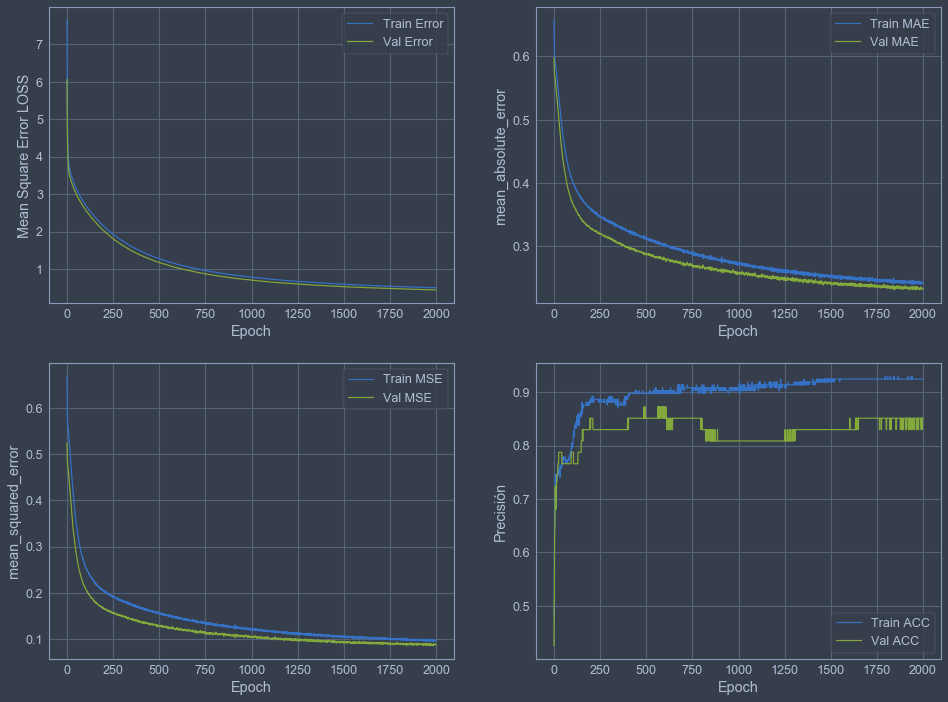

In [80]:
plot_history(history)

Ahora es momento de predecir ya que la red neuronal se encuentra entrenada

In [16]:
y_predic= model.predict(X_test)

Es posible calcular la diferencia entre la prediccion y los datos tomados desde la serie de tiempo

In [17]:
r = y_test - y_predic
ab = abs(r)

Ahora se puede revizar unos datos interesantes

In [18]:
print('Media:', r.mean())
print('Maximo:', ab.max())
print('Minimo:', ab.min())
print('STD:', r.std())

Media: -0.010071162801426819
Maximo: 0.5531872740453161
Minimo: 0.0009777580482415171
STD: 0.1792532738978657


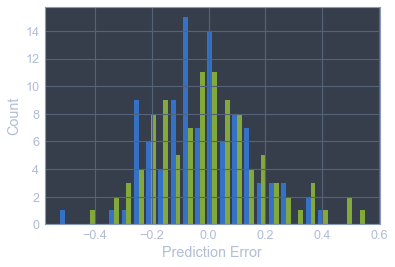

In [19]:
plt.hist(r, bins = 25)
plt.xlabel("Prediction Error")
_ = plt.ylabel("Count")

<h3>Guardar el modelo entrenado </h3>

In [20]:
#model.save('modelo_serie_electrica3.h5')